<style>
  .navbar {
    background-color: #f7f7f7;
    display: flex;
    justify-content: space-between;
    align-items: center;
    overflow: hidden;
    font-family: 'Montserrat', 'Arial', sans-serif;
    padding: 10px;
    height: 90px;
    box-shadow: 0 2px 4px rgba(0,0,0,0.2);
  }

  .navbar a {
    font-size: 18px;
    text-align: center;
    padding: 14px 16px;
    text-decoration: none;
    transition: color 0.3s ease-in-out;
    color: #0f5b99
  }

  .navbar a:hover {
    background-color: #eaeaea;
    color: #ff5500;
  }

  .navbar img {
    height: 'auto';
    width: 300px
  }
</style>

<div class="navbar" id="inizio">
  <a href="descrizione_problema.html">Descrizione del problema</a>
  <a href="data_preprocessing.html">Data Preprocessing</a>
  <a href="approccio_3D.html">Approccio 3D</a>
  <a href="approccio_2D.html">Approccio 2D</a>
  <a href="https://www.unipa.it"><img src="https://www.unipa.it/redazioneweb/.content/immagini/logo-unipa-2020.png"></a>
</div>


# <strong> <center> STYLING DEL NOTEBOOK </center> </strong>
---

In [1]:
from IPython.core.display import HTML

HTML("""
        <style>
            @import url('https://fonts.googleapis.com/css?family=Montserrat&display=swap');
            
            * {
                font-family: 'Montserrat', 'Arial', sans-serif;
            }

        </style>
    """)

# <strong> <center> DATA PREPROCESSING </center> </strong>
---

La competizione da cui prende spunto questo progetto fornisce ai partecipanti un file strutturato `train.csv`, in cui sono catalogate, per ogni riga, un ID, un'etichetta di classificazione e una stringa RLE della maschera di segmentazione associata, e una cartella contenente le **scansioni MRI** di partenza, catalogate per caso clinico e giorno di osservazione.

Avendo a disposizione questi dati, frutto del processo di **Data Collection**, lo step successivo prevede il **Data Preprocessing**: questa fase si compone di una serie di operazioni che permettono di dare maggiore struttura al dataset a disposizione e di ricavare importanti elementi statistici per le fasi successive del processo.  

A seguito di una prima ispezione visiva e di uno studio preliminare del problema, compresa la metodologia di acquisizione MRI, opereremo sui
file a disposizione secondo la seguente **outline**:

<ol>
    <li><a href="#paragrafo_1" style="color: inherit; text-decoration: none;"> Operazioni sul file <code>train.csv</code> </a></li>
    <li><a href="#paragrafo_2" style="color: inherit; text-decoration: none;"> Raccolta e inventario delle immagini </a></li>
    <li><a href="#paragrafo_3" style="color: inherit; text-decoration: none;"> Statistiche delle immagini </a></li>
    <li><a href="#paragrafo_4" style="color: inherit; text-decoration: none;"> Operazioni sulle maschere </a></li>
    <li><a href="#paragrafo_5" style="color: inherit; text-decoration: none;"> Operazioni sulle slice </a></li>
    <li><a href="#paragrafo_6" style="color: inherit; text-decoration: none;"> Data Cleaning, Equalizzazione slice e Creazione maschere </a></li>
    <li><a href="#paragrafo_7" style="color: inherit; text-decoration: none;"> Cropping e Resize di slice e maschere </a></li>
</ol>

# <center id='paragrafo_1'> <strong>1 &dash; OPERAZIONI SUL FILE `train.csv` </strong> </center>
---

## Elenco `import`

In [ ]:
import cv2 as cv
import glob
from joblib import Parallel, delayed
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import tifffile as tiff

from itertools import zip_longest 
from IPython.display import display
from keras import layers
from tqdm import tqdm

os.environ["QT_QPA_PLATFORM"] = "xcb"

## Elenco `path`

In [4]:
TRAIN_DIR = os.path.join('./train/')
DATAFRAMES_DIR = os.path.join('./dataframes/')

VOLUMES_DIR = os.path.join('./volumes/')
DATASET_2D_DIR = os.path.join('./dataset_2D/')
DATASET_3D_DIR = os.path.join('./dataset_3D/')

SCANS_DIR = os.path.join(TRAIN_DIR, 'scans/')
MASKS_DIR = os.path.join(TRAIN_DIR, 'masks/') 

TRAIN_CSV = os.path.join(DATAFRAMES_DIR, 'train.csv')

## Creazione delle cartelle

In [ ]:
if not os.path.exists(VOLUMES_DIR):
    os.mkdir(VOLUMES_DIR) 
    os.mkdir(f'{VOLUMES_DIR}slices/')
    os.mkdir(f'{VOLUMES_DIR}masks/')

if not os.path.exists(DATASET_2D_DIR):
    os.mkdir(DATASET_2D_DIR)

## Creazione delle progress bar personalizzate

In [5]:
bar_format_red = "{l_bar}\x1b[31m{bar}\x1b[0m{r_bar}]"
bar_format_green = "{l_bar}\x1b[32m{bar}\x1b[0m{r_bar}]"
bar_format_yellow = "{l_bar}\x1b[33m{bar}\x1b[0m{r_bar}]"
bar_format_blue = "{l_bar}\x1b[34m{bar}\x1b[0m{r_bar}]"
bar_format_magenta = "{l_bar}\x1b[35m{bar}\x1b[0m{r_bar}]"
bar_format_cyan = "{l_bar}\x1b[36m{bar}\x1b[0m{r_bar}]"

## Considerazioni preliminari

Inizialmente, proviamo ad aprire il contenuto del file **train.csv**, fornito dai creatori della competizione, per osservarne il contenuto e avere una comprensione preliminare del problema.

In [6]:
train_df = pd.read_csv(TRAIN_CSV)

train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [7]:
len(train_df)

115488

Il file presenta una struttura formata da **115488** righe per 3 colonne, ossia:

* **id**, ossia l'identificativo associato ad un frame dell'acquisizione fatta in un dato giorno per uno specifico caso;
* **class**, cio&eacute; l'organo presente nella scansione;
* **segmentation**, ossia il segmento di immagine corrispondente all'organo individuato nella classe.

La prima cosa che vogliamo andare a vedere è il numero di elementi per ogni classe.

In [8]:
class_counts = train_df['class'].value_counts()

class_counts.values

array([38496, 38496, 38496])

Forniamo, quindi, una rappresentazione grafica di quanto trovato, tramite un grafico a barre in cui ad ogni colore è associata una
classe di segmentazione.

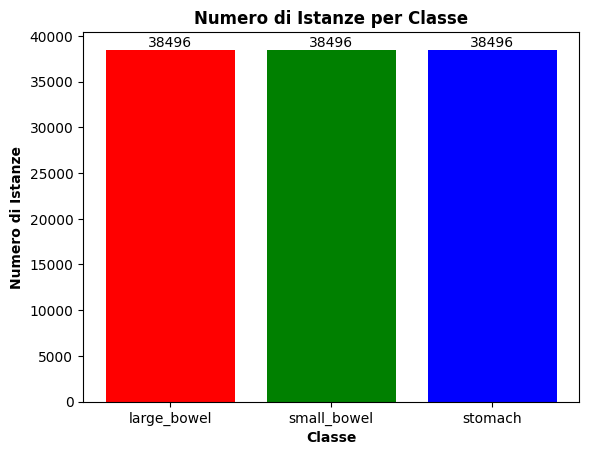

In [9]:
# Definizione dei colori delle barre
colors = ['red', 'green', 'blue']

# Creazione del grafico a barre
plt.bar(class_counts.index, class_counts.values, color=[colors[i] for i in range(len(class_counts))])

# Aggiunta delle etichette dell'asse x e y e del titolo del grafico
plt.xlabel('Classe', fontweight='bold')
plt.ylabel('Numero di Istanze', fontweight='bold')
plt.title('Numero di Istanze per Classe', fontweight='bold')

# Aggiunta delle etichette del valore
for i, v in enumerate(class_counts.values):
    plt.text(i, v, str(v), color='black', ha='center', va='bottom')

# Mostrare il grafico
plt.show()

Quello che notiamo è che il numero di elementi appartenenti ad ogni classe, **large_bowel**, **small_bowel** e **stomach**, è lo stesso, 38496, cosa ipotizzabile *ad occhio* nel dataframe precedentemente importato.

L'altra colonna rilevante del dataframe è quella di *segmentation*, che viene usata per indicare le maschere corrispondenti all'organo classificato. Come prima cosa, vogliamo evidenziare solo le istanze del DataFrame che hanno una segmentazione non nulla (i.e. diversa da NaN).

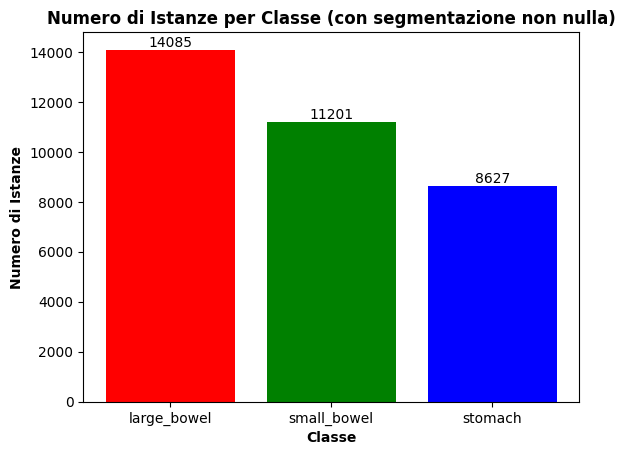

In [10]:
# Eliminazione delle righe con valori mancanti nella colonna "segmentation"
df_filtered = train_df.dropna(subset=['segmentation'])

# Calcolo del numero di istanze per ogni classe nella colonna "class" del DataFrame filtrato
class_counts = df_filtered['class'].value_counts()

# Creazione del grafico a barre con colori personalizzati per ogni classe
colors = ['red', 'green', 'blue']
plt.bar(class_counts.index, class_counts.values, color=[colors[i] for i in range(len(class_counts))])

# Aggiunta delle etichette dell'asse x e y e del titolo del grafico
plt.xlabel('Classe', fontweight='bold')
plt.ylabel('Numero di Istanze', fontweight='bold')
plt.title('Numero di Istanze per Classe (con segmentazione non nulla)', fontweight='bold')

# Aggiunta delle etichette del valore
for i, v in enumerate(class_counts.values):
    plt.text(i, v, str(v), color='black', ha='center', va='bottom')

# Mostrare il grafico
plt.show()

Abbiamo costruito, a partire dal dataframe originale, un secondo dataframe, chiamato *df_filtered* tramite la funzione 
`dropna()` di `pandas.Dataframe` per eliminare le righe con valori mancanti (i.e. NaN) nella colonna *segmentation*.

Successivamente, in maniera analoga al calcolo delle istanze di classe, abbiamo utilizzato il dataframe appena creato per calcolare il numero 
di istanze per ogni classe nella colonna *class*, utilizzando la funzione `value_counts()` di `pandas.Dataframe`. 

Infine, abbiamo creato un grafico a barre con i risultati e abbiamo aggiunto le etichette dell'asse x, dell'asse y e del titolo del grafico.

## Prima preparazione

L'obiettivo di questa seconda parte di operazioni sul file **train.csv** è quello di estrarre delle informazioni che possano tornare utili in fase di analisi del problema e di eventuali operazioni di *data cleaning* (visto l'elevato numero di slice prive di maschere è facile aspettarsi un calo drastico delle dimensioni del dataset).

Inizialmente, effettuiamo una semplice conversione di notazione per la classificazione: piuttosto che usare una label categorica, passiamo ad una classificazione per valori interi discreti.

In [11]:
class_mapping = {'large_bowel': 0, 'small_bowel': 1, 'stomach': 2}

train_df['class'] = train_df['class'].replace(class_mapping)

Successivamente, a partire dalla colonna **id** del dataframe di partenza, si può osservare come ogni riga contenga informazioni circa la categorizzazione per numero del **caso** clinico, per **giornata** di osservazione e per **numero di frame** dell'acquisizione. L'obiettivo diventa, quindi, quello di estrarre le suddette informazioni e di ristrutturare il dataframe.

Inizialmente, elaboriamo, per ogni riga, il valore di **id**, in modo da estrarre una lista di informazioni

In [12]:
splits = train_df['id'].str.split("_", n = 4, expand = True)

splits.head()

,0,1,2,3
0,case123,day20,slice,0001
1,case123,day20,slice,0001
2,case123,day20,slice,0001
3,case123,day20,slice,0002
4,case123,day20,slice,0002


Come si può vedere nella tabella precedente, le informazioni che possiamo estrarre si trovano nei chunk 0, 1 e 3. 

Ciò che ci interessa è, però, dare un'impostazione ai dati più quantitativa, per cui dobbiamo estrarre dai chunk 0 e 1, rispettivamente, il numero del caso e della giornata di osservazione, mentre il chunk 3 va solo inteso come un numero intero, per eliminare gli 0 iniziali.

In [13]:
train_df['case_id'] = splits[0]
train_df['day_id'] = splits[1]
train_df['slice_id'] = splits[3].astype(int)

train_df['case_id'] = train_df['case_id'].str.replace('case', '').astype(int) 
train_df['day_id'] = train_df['day_id'].str.replace('day', '').astype(int)

train_df.head()

,id,class,segmentation,case_id,day_id,slice_id
0,case123_day20_slice_0001,0,NaN,123,20,1
1,case123_day20_slice_0001,1,NaN,123,20,1
2,case123_day20_slice_0001,2,NaN,123,20,1
3,case123_day20_slice_0002,0,NaN,123,20,2
4,case123_day20_slice_0002,1,NaN,123,20,2


In [14]:
filtered = train_df.groupby(['case_id', 'day_id'])

count = 0

for group in filtered:
    count_nan = 0
    for element in group[1]['segmentation']:
        if pd.isna(element):
            count_nan += 1
    if count_nan == len(group[1]):
        print(group[0])
    count_nan = 0
    count += 1
if(count == len(filtered)):
    print("Il numero delle righe coincide! Non esistono quindi casi che non hanno ALMENO un attributo di segmentazione.")

Il numero delle righe coincide! Non esistono quindi casi che non hanno ALMENO un attributo di segmentazione.


Adesso vogliamo compattare il dataframe, in modo che la singola riga contenga le informazioni della coppia `(class, segmentation)` per la tripla `(large_bowel, small_bowel, stomach)`, e ordinarlo in ordine crescente per numero del caso, giornata di osservazione e identificativo della scansione. Per farlo, dobbiamo:

* Rimuovere le colonne *class* e *segmentation* e salvarlo in due liste opportune

In [15]:
classe = train_df.pop('class')
segmentation = train_df.pop('segmentation')

* Raggruppare gli elementi in gruppi da tre e rimuovere i duplicati per *id*

In [ ]:
grouped_segmentation = list(zip_longest(*[iter(segmentation)]*3, fillvalue=None))
grouped_class = list(zip_longest(*[iter(classe)]*3, fillvalue=None))

train_df = train_df.drop_duplicates(subset=['id'])

train_df.insert(len(train_df.columns), 'class', grouped_class)
train_df.insert(len(train_df.columns), 'segmentation', grouped_segmentation)

# converto i valori dell'attributo 'segmentation' in stringhe
train_df.loc[:, 'segmentation'] = train_df['segmentation'].apply(str)

* Ordinare il dataframe per *case_id*, *day_id* e *slice_id*

In [17]:
train_df = train_df.sort_values(by=['case_id', 'day_id', 'slice_id'], ascending=True).reset_index(drop=True)

train_df.head()

,id,case_id,day_id,slice_id,class,segmentation
0,case2_day1_slice_0001,2,1,1,"(0, 1, 2)","(nan, nan, nan)"
1,case2_day1_slice_0002,2,1,2,"(0, 1, 2)","(nan, nan, nan)"
2,case2_day1_slice_0003,2,1,3,"(0, 1, 2)","(nan, nan, nan)"
3,case2_day1_slice_0004,2,1,4,"(0, 1, 2)","(nan, nan, nan)"
4,case2_day1_slice_0005,2,1,5,"(0, 1, 2)","(nan, nan, nan)"


# <center id='paragrafo_2'> <strong>2 &dash; RACCOLTA E INVENTARIO DELLE IMMAGINI </strong> </center>
---

Dopo aver osservato alcuni aspetti interessanti sui dati forniti dal problema, vogliamo andare ad indagare maggiormente sulle immagini delle varie scansioni. Per evitare di avere un dataframe poco leggibile, umanamente parlando, ricorriamo ad un secondo dataframe, realizzato da zero, a partire dai percorsi estratti dalla cartella *train* e associati alle *scans*.

In [18]:
list_slices = glob.glob(TRAIN_DIR+'*/*/scans/*.png')

image_details = pd.DataFrame({'slice_path':list_slices})

image_details.head()

,slice_path
0,./train/case149/case149_day12/scans/slice_0100...
1,./train/case149/case149_day12/scans/slice_0084...
2,./train/case149/case149_day12/scans/slice_0080...
3,./train/case149/case149_day12/scans/slice_0108...
4,./train/case149/case149_day12/scans/slice_0038...


Adesso, a partire dai persorsi individuati, possiamo andare ad estrarre le informazioni che ci interessa possano essere associati alle singole immagini:

1. **Numero del caso**
2. **Giorno di osservazione**
3. **Numero della slice**
4. **Altezza dell'immagine**
5. **Larghezza dell'immagine**
6. **Altezza del singolo pixel**
7. **Larghezza del singolo pixel**

In [19]:
splits = image_details['slice_path'].str.split("/", n = 6, expand = True)

image_details[['case_id', 'day_id']] = splits[3].str.split("_", expand = True)

image_details['case_id'] = image_details['case_id'].str.replace('case', '').astype(int) 
image_details['day_id'] = image_details['day_id'].str.replace('day', '').astype(int)

image_details['slice_name'] = splits[5]

slice_info = image_details['slice_name'].str.split(n=6, expand=True, pat="_")

image_details['slice_id'] = slice_info[1].astype(int)

image_details['width'] = slice_info[2].astype(int)
image_details['height'] = slice_info[3].astype(int)

image_details['width_px'] = slice_info[4].astype(float)
image_details['height_px'] = slice_info[5].str.replace('.png', '', regex=False).astype(float)

splits[4] = splits[4].str.replace('scans', 'masks')
splits[5] = splits[5].str.replace('slice', 'mask_slice')

percorsi_cartelle = splits.drop(columns=[5])

percorsi_cartelle = percorsi_cartelle.apply(lambda x: '/'.join(x.astype(str)), axis=1)

percorsi_maschere = splits.apply(lambda x: '/'.join(x.astype(str)), axis=1)

image_details.insert(1, 'mask_path', percorsi_maschere)

A partire dalle informazioni estratte, possiamo preparare una struttura di directory che metta in parallelo, 
per caso clinico e giorno di osservazione, le slice e le maschere; di conseguenza, procediamo alla creazione
delle cartelle che ospiteranno le maschere.

In [37]:
print(f"\nInizio creazione cartelle maschere...\n") 
for path in tqdm(percorsi_cartelle, total=len(percorsi_cartelle), bar_format=bar_format_blue):
    # Creo la nuova cartella se non esiste già
    if not os.path.exists(path):
        os.mkdir(path) 
print(f"\nFine creazione cartelle maschere.\n")   


Inizio creazione cartelle maschere...



100%|██████████| 38496/38496 [00:00<00:00, 205339.68it/s]]


Fine creazione cartelle maschere.



Ordiniamo, quindi, in ordine **crescente** per numero del caso, giornata di osservazione e numero della slice, il dataframe appena costruito.

In [38]:
image_details = image_details.sort_values(by=['case_id', 'day_id', 'slice_id'], ascending=True).reset_index(drop=True)

image_details.head()

,slice_path,mask_path,case_id,day_id,slice_name,slice_id,width,height,depth_px
0,./train/case2/case2_day1/scans/slice_0001_266_...,./train/case2/case2_day1/masks/mask_slice_0001...,2,1,slice_0001_266_266_1.50_1.50.png,1,266,266,1.5
1,./train/case2/case2_day1/scans/slice_0002_266_...,./train/case2/case2_day1/masks/mask_slice_0002...,2,1,slice_0002_266_266_1.50_1.50.png,2,266,266,1.5
2,./train/case2/case2_day1/scans/slice_0003_266_...,./train/case2/case2_day1/masks/mask_slice_0003...,2,1,slice_0003_266_266_1.50_1.50.png,3,266,266,1.5
3,./train/case2/case2_day1/scans/slice_0004_266_...,./train/case2/case2_day1/masks/mask_slice_0004...,2,1,slice_0004_266_266_1.50_1.50.png,4,266,266,1.5
4,./train/case2/case2_day1/scans/slice_0005_266_...,./train/case2/case2_day1/masks/mask_slice_0005...,2,1,slice_0005_266_266_1.50_1.50.png,5,266,266,1.5


Creiamo un nuovo dataframe, frutto dell'unione di `train_df` e `image_details`, secondo gli attributi comuni `case_id`, `day_id` e `slice_id`.

In [39]:
merged_df = pd.merge(train_df, image_details, on=['case_id', 'day_id', 'slice_id'])
merged_df.head()

,id,case_id,day_id,slice_id,class,segmentation,slice_path,mask_path,slice_name,width,height,depth_px
0,case2_day1_slice_0001,2,1,1,"(0, 1, 2)","(nan, nan, nan)",./train/case2/case2_day1/scans/slice_0001_266_...,./train/case2/case2_day1/masks/mask_slice_0001...,slice_0001_266_266_1.50_1.50.png,266,266,1.5
1,case2_day1_slice_0002,2,1,2,"(0, 1, 2)","(nan, nan, nan)",./train/case2/case2_day1/scans/slice_0002_266_...,./train/case2/case2_day1/masks/mask_slice_0002...,slice_0002_266_266_1.50_1.50.png,266,266,1.5
2,case2_day1_slice_0003,2,1,3,"(0, 1, 2)","(nan, nan, nan)",./train/case2/case2_day1/scans/slice_0003_266_...,./train/case2/case2_day1/masks/mask_slice_0003...,slice_0003_266_266_1.50_1.50.png,266,266,1.5
3,case2_day1_slice_0004,2,1,4,"(0, 1, 2)","(nan, nan, nan)",./train/case2/case2_day1/scans/slice_0004_266_...,./train/case2/case2_day1/masks/mask_slice_0004...,slice_0004_266_266_1.50_1.50.png,266,266,1.5
4,case2_day1_slice_0005,2,1,5,"(0, 1, 2)","(nan, nan, nan)",./train/case2/case2_day1/scans/slice_0005_266_...,./train/case2/case2_day1/masks/mask_slice_0005...,slice_0005_266_266_1.50_1.50.png,266,266,1.5


Inseriamo anche gli attributi `is_created_mask`, `is_equalized_slice` attualmente impostati a `False`, che serviranno successivamente.

In [40]:
merged_df['is_created_mask'] = [False] * merged_df.shape[0]
merged_df['is_equalized_slice'] = [False] * merged_df.shape[0]

Salviamo, quindi, il dataframe `merged_df` in un file csv, in modo da potervi accedere in qualsiasi momento:

In [41]:
merged_df.to_csv(f'{DATAFRAMES_DIR}merged_df.csv', index=False)

# <center id='paragrafo_3'> <strong>3 &dash; STATISTICHE DELLE IMMAGINI </strong> </center>
---

A seguito di ispezione visiva, abbiamo notato che alcune immagini erano, di base, qualitativamente migliori di altre. Quello che vogliamo fare, allora, è cercare di trovare qualche correlazione tra le caratteristiche dell'immagine e la sua qualità.

## Distribuzioni delle immagini in base alla profondità dei pixel 

Il dataframe ci permette di evidenziare la presenza di due possibili valori per la profondità delle immagini, ossia $1.50\text{ mm}$ e $1.63\text{ mm}$. Innanzitutto, proviamo ad osservare la distribuzione delle immagini sulla base dei suddetti valori.

In [42]:
num_images_150 = image_details.loc[(image_details['width_px'] == 1.50) & (image_details['height_px'] == 1.50)].shape[0]
print(f"Il numero di immagini con pixel di profondità pari a \033[1;34m1.50 mm\033[0m è \033[1;34m{num_images_150}\033[0m")

num_images_163 = image_details.loc[(image_details['width_px'] == 1.63) & (image_details['height_px'] == 1.63)].shape[0]
print(f"Il numero di immagini con pixel di profondità pari a \033[1;34m1.63 mm\033[0m è \033[1;34m{num_images_163}\033[0m")

print(f"Il numero complessivo di immagini è \033[1;34m{len(image_details)}\033[0m, esattamente pari a \033[1;34m{num_images_150} + {num_images_163}\033[0m")

Il numero di immagini con pixel di profondità pari a 1.50 mm è 37296
Il numero di immagini con pixel di profondità pari a 1.63 mm è 1200
Il numero complessivo di immagini è 38496, esattamente pari a 37296 + 1200


Avendo controllato che la somma di entrambi i numeri resituisse esattamente 38496, il numero complessivo di immagini, 
rappresentiamo tale distribuzione in un grafico a barre.

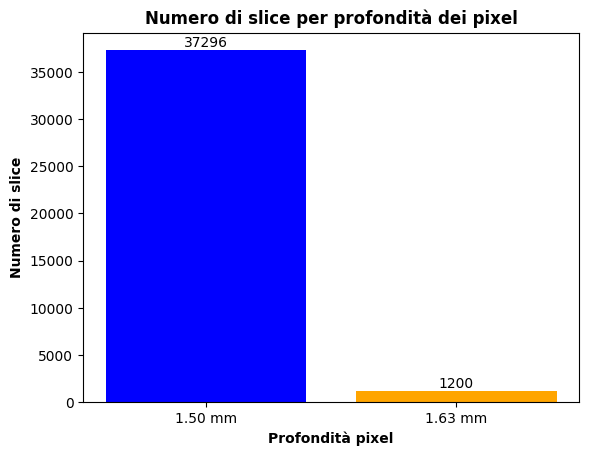

In [43]:
labels = ['1.50 mm', '1.63 mm']
num_images = [num_images_150, num_images_163]

colors = ['blue', 'orange']

fig, ax = plt.subplots()
ax.bar(labels, num_images, color=colors)

ax.set_title('Numero di slice per profondità dei pixel', fontweight='bold')
ax.set_xlabel('Profondità pixel', fontweight='bold')
ax.set_ylabel('Numero di slice', fontweight='bold')

# Aggiunta delle etichette del valore
for i, v in enumerate(num_images):
    plt.text(i, v, str(v), color='black', ha='center', va='bottom')

plt.show()

## Relazioni tra profondità dei pixel e dimensioni dell'immagine

In questa seconda parte dell'indagine statistica, vogliamo andare a vedere anche quale sia l'associazione tra la dimensione dei pixel e la risultante dimensione complessiva dell'immagine, così come se questa possa avere un layout quadrato o in landscape.

Per poter fare delle considerazioni, dobbiamo innanzitutto, vedere, per ogni dimensione del pixel, quali valori di altezza e larghezza globali si ottengono.

In [44]:
widths_px_1_50 = image_details[(image_details['width_px'] == 1.50) & (image_details['height_px'] == 1.50)]['width'].unique()
print(f"Le immagini associate a una profondità dei pixel pari a \033[1;34m1.50 mm\033[0m hanno una larghezza (in pixel) tra \033[1;34m{widths_px_1_50}\033[0m")

heights_px_1_50 = image_details[(image_details['width_px'] == 1.50) & (image_details['height_px'] == 1.50)]['height'].unique()
print(f"Le immagini associate a una profondità dei pixel pari a \033[1;34m1.50 mm\033[0m hanno un'altezza (in pixel) tra \033[1;34m{heights_px_1_50}\033[0m")

widths_px_1_63 = image_details[(image_details['width_px'] == 1.63) & (image_details['height_px'] == 1.63)]['width'].unique()
print(f"Le immagini associate a una profondità dei pixel pari a \033[1;34m1.63 mm\033[0m hanno una larghezza (in pixel) tra \033[1;34m{widths_px_1_63}\033[0m")

heights_px_1_63 = image_details[(image_details['width_px'] == 1.63) & (image_details['height_px'] == 1.63)]['height'].unique()
print(f"Le immagini associate a una profondità dei pixel pari a \033[1;34m1.63 mm\033[0m hanno un'altezza (in pixel) tra \033[1;34m{heights_px_1_63}\033[0m")

Le immagini associate a una profondità dei pixel pari a 1.50 mm hanno una larghezza (in pixel) tra [266 360 234]
Le immagini associate a una profondità dei pixel pari a 1.50 mm hanno un'altezza (in pixel) tra [266 310 234]
Le immagini associate a una profondità dei pixel pari a 1.63 mm hanno una larghezza (in pixel) tra [276]
Le immagini associate a una profondità dei pixel pari a 1.63 mm hanno un'altezza (in pixel) tra [276]


Si evince che le slice con profondità dei pixel pari a $1.50 \text{ mm}$ hanno dimensione variabile, mentre quelle a profondità pari a $1.63 \text{ mm}$ hanno tutte la stessa dimensione $\left(276\times 276\right)$ 

## Statistica delle dimensioni globali delle immagini

Volendo approfondire quanto visto nel paragrafo precedente, abbiamo pensato avesse senso indagare su quali fossero le dimensioni delle slice nel dataset. Motivati da questa curiosità, e ricercando possibili correlazioni statistiche con la qualità dell'immagine/con la presenza di segmentazione, cerchiamo, per ogni dimensione, i valori corrispondenti per l'altra dimensione.

Come prima cosa, analizziamo le immagini in cui almeno una dimensione è $266 \text{ px}$:

In [45]:
num_images_266_width = image_details.loc[(image_details['width'] == 266)].shape[0]
print(f"Il numero di immagini con larghezza \033[1;34m266 px\033[0m è pari a: \033[1;34m{num_images_266_width}\033[0m")

num_images_266_height = image_details.loc[(image_details['height'] == 266)].shape[0]
print(f"Il numero di immagini con altezza \033[1;34m266 px\033[0m è pari a: \033[1;34m{num_images_266_height}\033[0m")

num_images_266x266 = image_details.loc[(image_details['width'] == 266) & (image_details['height'] == 266)].shape[0]
print(f"Il numero di immagini \033[1;34m266x266\033[0m è pari a: \033[1;34m{num_images_266x266}\033[0m")

Il numero di immagini con larghezza 266 px è pari a: 25920
Il numero di immagini con altezza 266 px è pari a: 25920
Il numero di immagini 266x266 è pari a: 25920


Ne abbiamo dedotto che le immagini con altezza o larghezza $266 \text{ px}$ sono **quadrate**. Continuiamo, quindi, l'analisi con le immagini in cui almeno una dimensione è $234 \text{ px}$:

In [46]:
num_images_234_width = image_details.loc[(image_details['width'] == 234)].shape[0]
print(f"Il numero di immagini con larghezza \033[1;34m234 px\033[0m è pari a: \033[1;34m{num_images_234_width}\033[0m")

num_images_234_height = image_details.loc[(image_details['height'] == 234)].shape[0]
print(f"Il numero di immagini con altezza \033[1;34m234 px\033[0m è pari a: \033[1;34m{num_images_234_height}\033[0m")

num_images_234x234 = image_details.loc[(image_details['width'] == 234) & (image_details['height'] == 234)].shape[0]
print(f"Il numero di immagini \033[1;34m234x234\033[0m è pari a: \033[1;34m{num_images_234x234}\033[0m")

Il numero di immagini con larghezza 234 px è pari a: 144
Il numero di immagini con altezza 234 px è pari a: 144
Il numero di immagini 234x234 è pari a: 144


Anche qui, risulta come una dimensione a $234 \text{ px}$ sia associata a immagini **quadrate**. &Egrave; banale affermare che le rimanenti immagini a profondità $1.50 \text{ mm}$ sono **rettangolari** $\left( 360\times 310 \right)$.<br>
Nel seguente listato, andiamo a provare quanto affermato:

In [47]:
num_images_360_width = image_details.loc[(image_details['width'] == 360)].shape[0]
print(f"\nIl numero di immagini con larghezza \033[1;34m360 px\033[0m è pari a: \033[1;34m{num_images_360_width}\033[0m")

num_images_310_height = image_details.loc[(image_details['height'] == 310)].shape[0]
print(f"Il numero di immagini con altezza \033[1;34m310 px\033[0m è pari a: \033[1;34m{num_images_310_height}\033[0m")

num_images_360x310 = image_details.loc[(image_details['width'] == 360) & (image_details['height'] == 310)].shape[0]
print(f"Il numero di immagini \033[1;34m360x310\033[0m è pari a: \033[1;34m{num_images_360x310}\033[0m")

tot_slice = num_images_266x266 + num_images_234x234 + num_images_360x310
print(f"\nIl totale delle slice con profondità dei pixel pari a \033[1;34m1.50 mm\033[0m è: \033[1;34m{tot_slice}\033[0m")

Il numero di immagini con larghezza 360 px è pari a: 11232
Il numero di immagini con altezza 310 px è pari a: 11232
Il numero di immagini 360x310 è pari a: 11232

Il totale delle slice con profondità dei pixel pari a 1.50 mm è: 37296


Osserviamo graficamente quanto affermato in questa sezione.

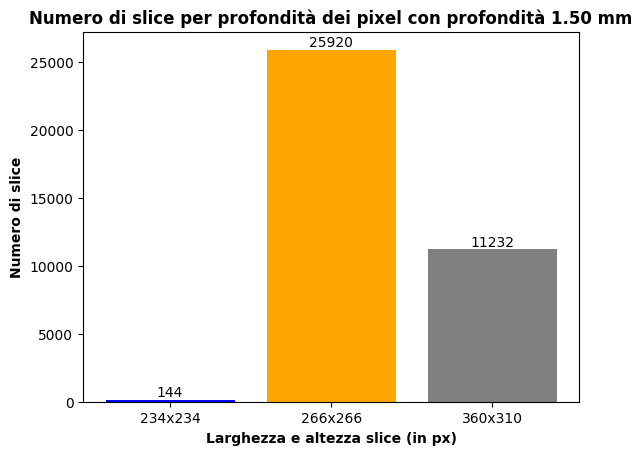

In [48]:
labels = ['234x234', '266x266', '360x310']
num_slices = [num_images_234x234, num_images_266x266, num_images_360x310]
colors = ['grey', 'orange', 'blue']

plt.bar(labels, num_slices, color=colors)
plt.title('Numero di slice per profondità dei pixel con profondità 1.50 mm', fontweight='bold')
plt.xlabel('Larghezza e altezza slice (in px)', fontweight='bold')
plt.ylabel('Numero di slice', fontweight='bold')

# Aggiunta delle etichette del valore
for i, v in enumerate(num_slices):
    plt.text(i, v, str(v), color='black', ha='center', va='bottom')

plt.show()

## Statistiche dei volumi

Volendo perseguire un approccio di analisi dei volumi (dato che le scansioni MRI generano volumi), abbiamo ritenuto opportuno controllare le profondità dei volumi del dataset, cercando una relazione con la profondità descritta nel campo `depth` associato alla singola slice.

Il seguente codice presenta il controllo effettuato:

In [49]:
d1_50 = merged_df.loc[merged_df['depth_px'] == 1.50].groupby(['case_id', 'day_id']).size()

for row in pd.DataFrame(d1_50).iterrows():
    if row[1][0] != 144:
        print(row[0])

d1_63 = merged_df.loc[merged_df['depth_px'] == 1.63].groupby(['case_id', 'day_id']).size()

for row in pd.DataFrame(d1_63).iterrows():
    if row[1][0] != 80:
        print(row[0])

Non avendo ottenuto nulla in output in nessuno di entrambi i casi, possiamo affermare che le slice la cui profondità è $1.50\ \text{mm}$ appartengono sempre e comunque a giornate di acquisizioni costituite da **144 campioni** e che le slice la cui profondità è $1.63\ \text{mm}$ appartengono a giornate di acquisizioni costituite da **80 campioni**.

Spinti dalla curiosità per questo diverso numero di scansioni, vogliamo capire se tale valore può essere associato ad uno specifico caso clinico (i.e. tutte le scansioni volumetriche associate al paziente X hanno 144 campioni) o se vi sono altri tipi di dipendenze. \
Usiamo il seguente listato per verificare questa ipotesi:

In [50]:
grouped = merged_df.groupby('case_id')

for case_id, group in grouped:
    
    unique_depth_px = group['depth_px'].unique()
    if len(unique_depth_px) != 1:
        print(f"Il \033[1;34mcaso {case_id}\033[0m ha più valori unici dell'attributo '\033[1;34mdepth_px\033[0m'. In particolare essi sono pari a: \033[1;34m{unique_depth_px[0]} mm\033[0m e \033[1;34m{unique_depth_px[1]} mm\033[0m.")

Il caso 35 ha più valori unici dell'attributo 'depth_px'. In particolare essi sono pari a: 1.5 mm e 1.63 mm.
Il caso 89 ha più valori unici dell'attributo 'depth_px'. In particolare essi sono pari a: 1.5 mm e 1.63 mm.
Il caso 117 ha più valori unici dell'attributo 'depth_px'. In particolare essi sono pari a: 1.5 mm e 1.63 mm.
Il caso 118 ha più valori unici dell'attributo 'depth_px'. In particolare essi sono pari a: 1.63 mm e 1.5 mm.
Il caso 131 ha più valori unici dell'attributo 'depth_px'. In particolare essi sono pari a: 1.5 mm e 1.63 mm.
Il caso 146 ha più valori unici dell'attributo 'depth_px'. In particolare essi sono pari a: 1.5 mm e 1.63 mm.


A differenza di quanto ci aspettavamo, si rilevano alcuni casi, come il **131** e il **146**, in cui la profondità di acquisizione **non è rimasta costante nel periodo** di osservazione. A seguito di ispezione visiva, abbiamo constatato che per alcuni dei casi restituiti in output, vi sono delle giornate in cui la risoluzione spaziale e/o la profondità di acquisizione sono variate.

Volendo capire il motivo di una tale variazione, abbiamo approfondito le possibili cause, rilevando che, in generale, quando si effettuano scansioni MRI per il tratto gastrointestinale, **la quantità di dati acquisiti dipende dal campo magnetico utilizzato e dalle impostazioni di acquisizione**. In particolare, con un campo magnetico più elevato e con una maggiore densità di dati acquisiti, si può ottenere una migliore risoluzione spaziale e, di conseguenza, una maggiore definizione delle strutture anatomiche.

Tuttavia, in alcuni casi i **medici possono scegliere di utilizzare un campo magnetico inferiore e/o di ridurre la quantità di dati acquisiti** per motivi diversi, come ad esempio la necessità di ridurre il tempo di acquisizione, l'impossibilità di mantenere il paziente fermo per lunghi periodi di tempo o la necessità di limitare l'esposizione del paziente ai campi magnetici. 
Ad esempio, pazienti con problemi di claustrofobia potrebbero preferire una macchina con campo magnetico più basso, in quanto il tubo dello scanner è generalmente più corto e meno angusto rispetto alle macchine con campo magnetico più elevato. Inoltre, pazienti con pacemaker o altri dispositivi medici impiantati potrebbero non essere in grado di sottoporsi a una risonanza magnetica ad alto campo a causa dei rischi di interferenza magnetica.

Inoltre, i tumori avanzati possono richiedere un campo magnetico più elevato per fornire immagini di qualità sufficiente per la diagnosi e la pianificazione del trattamento. Ciò è dovuto al fatto che i tumori avanzati possono avere una maggiore eterogeneità dei tessuti e una maggiore quantità di tessuto cicatriziale, che possono influire sulla qualità delle immagini. 

Quindi, se i casi con **144** scansioni giornaliere hanno una percentuale minore di maschere di segmentazione rispetto a quelli con **80** scansioni, dovrebbe essere perché **per i primi è stato utilizzato un campo magnetico inferiore e/o una quantità di dati acquisiti inferiore** rispetto ai secondi, con la ricaduta di una **minore risoluzione spaziale** e una **minore definizione delle strutture anatomiche** (cosa che ne ha reso difficile la segmentazione).

## Statistiche della segmentazione

Avendo evidenziato quelle che sono le possibili dimensioni per le slice del dataset, vogliamo capire quante immagini, per ogni dimensione, presentassero segmentazione, cercando di trovare una qualche correlazione con la qualità dell'immagine.

Dal dataframe *image_details* estraiamo le righe le cui slice hanno data dimensione e calcoliamo i numeri relativi alla segmentazione:

* $234\times234$

In [51]:
image_details_234x234 = image_details[(image_details['width'] == 234) & (image_details['height'] == 234)].reset_index().drop(columns='index')
image_details_234x234.head()

,slice_path,mask_path,case_id,day_id,slice_name,slice_id,width,height,depth_px
0,./train/case139/case139_day0/scans/slice_0001_...,./train/case139/case139_day0/masks/mask_slice_...,139,0,slice_0001_234_234_1.50_1.50.png,1,234,234,1.5
1,./train/case139/case139_day0/scans/slice_0002_...,./train/case139/case139_day0/masks/mask_slice_...,139,0,slice_0002_234_234_1.50_1.50.png,2,234,234,1.5
2,./train/case139/case139_day0/scans/slice_0003_...,./train/case139/case139_day0/masks/mask_slice_...,139,0,slice_0003_234_234_1.50_1.50.png,3,234,234,1.5
3,./train/case139/case139_day0/scans/slice_0004_...,./train/case139/case139_day0/masks/mask_slice_...,139,0,slice_0004_234_234_1.50_1.50.png,4,234,234,1.5
4,./train/case139/case139_day0/scans/slice_0005_...,./train/case139/case139_day0/masks/mask_slice_...,139,0,slice_0005_234_234_1.50_1.50.png,5,234,234,1.5


In [52]:
image_details_234x234_w_seg = image_details_234x234.merge(train_df, on=['case_id', 'day_id', 'slice_id']).drop_duplicates()

count_234 = 0

for index, row in image_details_234x234_w_seg.iterrows():
    if row['segmentation'] == '(nan, nan, nan)':
        count_234 += 1

segmented_234 = image_details_234x234_w_seg.shape[0] - count_234

print(f"\nIl numero di righe con l'attributo '\033[1;34msegmentation\033[0m' diverso da \033[1;34m(nan, nan, nan)\033[0m è \033[1;34m{segmented_234}\033[0m.")
print(f"Il numero delle righe totali è \033[1;34m{image_details_234x234.shape[0]}\033[0m.")
print(f"\nCi sono esattamente \033[1;34m{count_234}\033[0m slice di dimensione \033[1;34m234x234\033[0m con maschere totalmente vuote.")
print(f"La percentuale di slice di dimensione \033[1;34m234x234\033[0m con maschere totalmente vuote è pari al \033[1;34m{round(count_234/image_details_234x234_w_seg.shape[0]*100, 2)}%\033[0m")

Il numero di righe con l'attributo 'segmentation' diverso da (nan, nan, nan) è 56.
Il numero delle righe totali è 144.

Ci sono esattamente 88 slice di dimensione 234x234 con maschere totalmente vuote.
La percentuale di slice di dimensione 234x234 con maschere totalmente vuote è pari al 61.11%


* $266\times266$

In [53]:
image_details_266x266 = image_details[(image_details['width'] == 266) & (image_details['height'] == 266)].reset_index().drop(columns='index')
image_details_266x266.head()

,slice_path,mask_path,case_id,day_id,slice_name,slice_id,width,height,depth_px
0,./train/case2/case2_day1/scans/slice_0001_266_...,./train/case2/case2_day1/masks/mask_slice_0001...,2,1,slice_0001_266_266_1.50_1.50.png,1,266,266,1.5
1,./train/case2/case2_day1/scans/slice_0002_266_...,./train/case2/case2_day1/masks/mask_slice_0002...,2,1,slice_0002_266_266_1.50_1.50.png,2,266,266,1.5
2,./train/case2/case2_day1/scans/slice_0003_266_...,./train/case2/case2_day1/masks/mask_slice_0003...,2,1,slice_0003_266_266_1.50_1.50.png,3,266,266,1.5
3,./train/case2/case2_day1/scans/slice_0004_266_...,./train/case2/case2_day1/masks/mask_slice_0004...,2,1,slice_0004_266_266_1.50_1.50.png,4,266,266,1.5
4,./train/case2/case2_day1/scans/slice_0005_266_...,./train/case2/case2_day1/masks/mask_slice_0005...,2,1,slice_0005_266_266_1.50_1.50.png,5,266,266,1.5


In [54]:
image_details_266x266_w_seg = image_details_266x266.merge(train_df, on=['case_id', 'day_id', 'slice_id']).drop_duplicates()

count_266 = 0

for index, row in image_details_266x266_w_seg.iterrows():
    if row['segmentation'] == '(nan, nan, nan)':
        count_266 += 1

segmented_266 = image_details_266x266_w_seg.shape[0] - count_266

print(f"\nIl numero di record con l'attributo '\033[1;34msegmentation\033[0m' diverso da \033[1;34m(nan, nan, nan)\033[0m è \033[1;34m{segmented_266}\033[0m.")
print(f"Il numero di record totali è \033[1;34m{image_details_266x266_w_seg.shape[0]}\033[0m.")
print(f"\nCi sono esattamente \033[1;34m{count_266}\033[0m slice di dimensione \033[1;34m266x266\033[0m con maschere totalmente vuote.")
print(f"La percentuale di slice di dimensione \033[1;34m266x266\033[0m con maschere totalmente vuote è pari al \033[1;34m{round(count_266/image_details_266x266_w_seg.shape[0]*100, 2)}%\033[0m")

Il numero di record con l'attributo 'segmentation' diverso da (nan, nan, nan) è 10955.
Il numero di record totali è 25920.

Ci sono esattamente 14965 slice di dimensione 266x266 con maschere totalmente vuote.
La percentuale di slice di dimensione 266x266 con maschere totalmente vuote è pari al 57.74%


* $276\times276$

In [55]:
image_details_276x276 = image_details[(image_details['width'] == 276) & (image_details['height'] == 276)].reset_index().drop(columns='index')
image_details_276x276.head()

,slice_path,mask_path,case_id,day_id,slice_name,slice_id,width,height,depth_px
0,./train/case34/case34_day0/scans/slice_0001_27...,./train/case34/case34_day0/masks/mask_slice_00...,34,0,slice_0001_276_276_1.63_1.63.png,1,276,276,1.63
1,./train/case34/case34_day0/scans/slice_0002_27...,./train/case34/case34_day0/masks/mask_slice_00...,34,0,slice_0002_276_276_1.63_1.63.png,2,276,276,1.63
2,./train/case34/case34_day0/scans/slice_0003_27...,./train/case34/case34_day0/masks/mask_slice_00...,34,0,slice_0003_276_276_1.63_1.63.png,3,276,276,1.63
3,./train/case34/case34_day0/scans/slice_0004_27...,./train/case34/case34_day0/masks/mask_slice_00...,34,0,slice_0004_276_276_1.63_1.63.png,4,276,276,1.63
4,./train/case34/case34_day0/scans/slice_0005_27...,./train/case34/case34_day0/masks/mask_slice_00...,34,0,slice_0005_276_276_1.63_1.63.png,5,276,276,1.63


In [56]:
image_details_276x276_w_seg = image_details_276x276.merge(train_df, on=['case_id', 'day_id', 'slice_id']).drop_duplicates()

count_276 = 0

for index, row in image_details_276x276_w_seg.iterrows():
    if row['segmentation'] == '(nan, nan, nan)':
        count_276 += 1

segmented_276 = image_details_276x276_w_seg.shape[0] - count_276

print(f"\nIl numero di record con l'attributo '\033[1;34msegmentation\033[0m' diverso da \033[1;34m(nan, nan, nan)\033[0m è \033[1;34m{segmented_276}\033[0m.")
print(f"Il numero dei record totali è \033[1;34m{image_details_276x276_w_seg.shape[0]}\033[0m.")
print(f"\nCi sono esattamente \033[1;34m{count_276}\033[0m slice di dimensione \033[1;34m276x276\033[0m con maschere totalmente vuote.")
print(f"La percentuale di slice di dimensione \033[1;34m276x276\033[0m con maschere totalmente vuote è pari al \033[1;34m{round(count_276/image_details_276x276_w_seg.shape[0]*100, 2)}%\033[0m")

Il numero di record con l'attributo 'segmentation' diverso da (nan, nan, nan) è 718.
Il numero dei record totali è 1200.

Ci sono esattamente 482 slice di dimensione 276x276 con maschere totalmente vuote.
La percentuale di slice di dimensione 276x276 con maschere totalmente vuote è pari al 40.17%


* $360\times310$

In [57]:
image_details_360x310 = image_details[(image_details['width'] == 360) & (image_details['height'] == 310)].reset_index().drop(columns='index')
image_details_360x310.head()

,slice_path,mask_path,case_id,day_id,slice_name,slice_id,width,height,depth_px
0,./train/case6/case6_day0/scans/slice_0001_360_...,./train/case6/case6_day0/masks/mask_slice_0001...,6,0,slice_0001_360_310_1.50_1.50.png,1,360,310,1.5
1,./train/case6/case6_day0/scans/slice_0002_360_...,./train/case6/case6_day0/masks/mask_slice_0002...,6,0,slice_0002_360_310_1.50_1.50.png,2,360,310,1.5
2,./train/case6/case6_day0/scans/slice_0003_360_...,./train/case6/case6_day0/masks/mask_slice_0003...,6,0,slice_0003_360_310_1.50_1.50.png,3,360,310,1.5
3,./train/case6/case6_day0/scans/slice_0004_360_...,./train/case6/case6_day0/masks/mask_slice_0004...,6,0,slice_0004_360_310_1.50_1.50.png,4,360,310,1.5
4,./train/case6/case6_day0/scans/slice_0005_360_...,./train/case6/case6_day0/masks/mask_slice_0005...,6,0,slice_0005_360_310_1.50_1.50.png,5,360,310,1.5


In [58]:
image_details_360x310_w_seg = image_details_360x310.merge(train_df, on=['case_id', 'day_id', 'slice_id']).drop_duplicates()

count_360 = 0

for index, row in image_details_360x310_w_seg.iterrows():
    if row['segmentation'] == '(nan, nan, nan)':
        count_360 += 1
        
segmented_360 = image_details_360x310_w_seg.shape[0] - count_360

print(f"\nIl numero di record con l'attributo '\033[1;34msegmentation\033[0m' diverso da \033[1;34m(nan, nan, nan)\033[0m è \033[1;34m{segmented_360}\033[0m.")
print(f"Il numero di record totali è \033[1;34m{image_details_360x310_w_seg.shape[0]}\033[0m.")
print(f"\nCi sono esattamente \033[1;34m{count_360}\033[0m slice di dimensione \033[1;34m360x310\033[0m con maschere totalmente vuote.")
print(f"La percentuale di slice di dimensione \033[1;34m360x310\033[0m con maschere totalmente vuote è pari al \033[1;34m{round(count_360/image_details_360x310_w_seg.shape[0]*100, 2)}%\033[0m")

Il numero di record con l'attributo 'segmentation' diverso da (nan, nan, nan) è 4861.
Il numero di record totali è 11232.

Ci sono esattamente 6371 slice di dimensione 360x310 con maschere totalmente vuote.
La percentuale di slice di dimensione 360x310 con maschere totalmente vuote è pari al 56.72%


Si evince che:

1.  le immagini che contengono, in percentuale, la **maggior frequenza di segmentazioni** sono quelle da $276\times276$ ($59.83\ \%$);
2.  le immagini che congengono la **maggior frequenza di segmentazioni totalmente vuote** sono quelle da $234\times234$ ($61.11\ \%$);
3.  le immagini che contengono il **maggior numero di immagini segmentate**, in valore assoluto, sono quelle da $266\times266$  ($10955$);
4.  le immagini che contengono il **minor numero di immagini segmentate** sono quelle da $234\times234$ ($56$).

Osserviamo graficamente, quanto visto analiticamente:

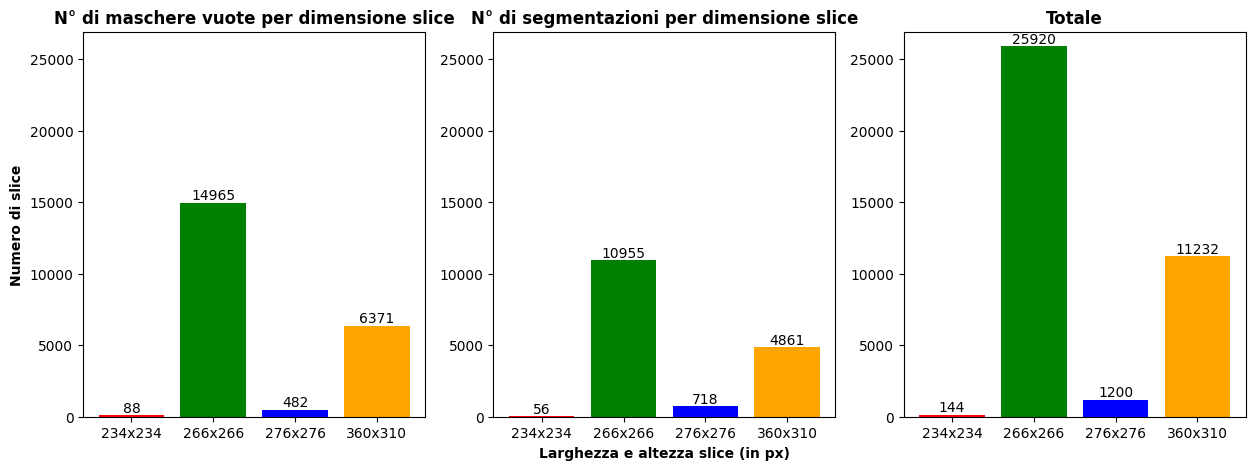

In [59]:
labels = ['234x234', '266x266', '276x276', '360x310']
counters1 = [count_234, count_266, count_276, count_360]
counters2 = [segmented_234, segmented_266, segmented_276, segmented_360]
counters3 = [(count_234 + segmented_234), (count_266 + segmented_266), (count_276 + segmented_276), (count_360 + segmented_360)]
colors = ['red', 'green', 'blue', 'orange']
lower_bound = 0
upper_bound = count_266 + segmented_266 + 1000

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.bar(labels, counters1, color=colors)
ax1.set_ybound(lower_bound, upper_bound)
ax1.set_title('N° di maschere vuote per dimensione slice', fontweight='bold')
ax1.set_ylabel('Numero di slice', fontweight='bold')

# Aggiunta delle etichette del valore
for i, v in enumerate(counters1):
    ax1.annotate(str(v), xy=(i, v), ha='center', va='bottom')

ax2.bar(labels, counters2, color=colors)
ax2.set_ybound(lower_bound, upper_bound)
ax2.set_title('N° di segmentazioni per dimensione slice', fontweight='bold')
ax2.set_xlabel('Larghezza e altezza slice (in px)', fontweight='bold')

# Aggiunta delle etichette del valore
for i, v in enumerate(counters2):
    ax2.annotate(str(v), xy=(i, v), ha='center', va='bottom')

ax3.bar(labels, counters3, color=colors)
ax3.set_ybound(lower_bound, upper_bound)
ax3.set_title('Totale', fontweight='bold')

# Aggiunta delle etichette del valore
for i, v in enumerate(counters3):
    ax3.annotate(str(v), xy=(i, v), ha='center', va='bottom')

plt.show()

In definitiva, ricaviamo che:

In [60]:
non_null_segm_df = merged_df.loc[merged_df['segmentation'] != '(nan, nan, nan)']

d1_50 = non_null_segm_df.loc[non_null_segm_df['depth_px'] == 1.50].groupby(['case_id', 'day_id']).size()

print(f"In media, viene mantenuto il \033[1;34m{round(np.average(np.array(d1_50.unique(), dtype=np.float16))/144, ndigits=4)*100}%\033[0m delle scansioni a profondità\033[1;34m 1.50 mm\033[0m\n")

d1_63 = non_null_segm_df.loc[non_null_segm_df['depth_px'] == 1.63].groupby(['case_id', 'day_id']).size()

print(f"In media, viene mantenuto il \033[1;34m{round(np.average(np.array(d1_63.unique(), dtype=np.float16))/80, ndigits=4)*100}%\033[0m delle scansioni a profondità\033[1;34m 1.63 mm\033[0m\n")

In media, viene mantenuto il 42.32% delle scansioni a profondità 1.50 mm

In media, viene mantenuto il 58.87% delle scansioni a profondità 1.63 mm



# <center id='paragrafo_4'> <strong>4 &dash; OPERAZIONI SULLE MASCHERE </strong> </center>
---

Avendo visto, nei paragrafi precedenti, l'esistenza di una colonna per la segmentazione degli organi all'interno delle scansioni e dopo averne evidenziato la distribuzione, in funzione delle dimensioni delle immagini, in questa sezione ci occuperemo di tutte le operazioni che abbiamo ritenuto necessarie per l'elaborazione delle maschere.

Come stabilito in fase di presentazione della competizione, le maschere di segmentazione del training set sono state fornite secondo la codifica **run-length**. 

Questa codifica (da ora RLE) è una semplice forma di **compressione** dei dati **senza perdita** di informazioni, che viene eseguita su sequenze con lo stesso valore che si verificano più volte consecutive. Codifica la sequenza per memorizzare un solo valore e il relativo conteggio.

Consideriamo, ad esempio, una porzione di maschera presa dal file `train.csv`:
**<center>24031 5 24296 7 24561 8 24825 10</center>** 

Contando da 0, gli elementi di posto **pari** indicano la posizione dei vari pixel nell'immagine vettorizzata, mentre gli elementi di posto **dispari** indicano la **lunghezza della run**, ovvero quante volte (meno uno) deve essere ripetuto il valore del pixel di riferimento.

Nel nostro esempio, il pixel **24031** andrà ripetuto **4** volte, il pixel **24296** andrà ripetuto **6** volte e così via.

Per sfruttare la codifica RLE delle maschere, procediamo all'implementazione delle funzioni per:

* creare una maschera vuota
* decodificare una stringa RLE
* codificare un'immagine in una stringa RLE

## Creazione maschera vuota

In [61]:
def crea_maschera_vuota(path: str, width: int, height: int):
    """Funzione usata per creare un segnaposto per una maschera
    in un dato percorso

    Args:
        path (str): percorso in cui salvare la maschera vuota
        width (int): larghezza desiderata per la maschera
        height (int): altezza desiderata per la maschera
    """
    # Creo una maschera vuota con le dimensioni dei pixel calcolate
    mask = np.zeros((height, width), dtype=np.uint8)

    cv.imwrite(path, mask)

&Egrave; una funzione molto semplice che serve a generare una maschera di larghezza e altezza desiderate, e a salvarla nel percorso specificato.

Tornerà utile per generare le maschere di segmentazione.

## Decodifica <strong>RLE</strong>

In [62]:
def rle_decode(rle_code: str, height: int, width: int) -> np.ndarray:
    """Funzione usata per convertire una maschera codificata RLE in 
    un'immagine di data altezza e larghezza

    Args:
        rle_code (str): stringa rappresentativa della segmentazione RLE
        height (int): altezza desiderata per l'immagine
        width (int): larghezza desiderata per l'immagine

    Returns:
        np.ndarray: immagine della maschera associata alla stringa RLE
    """
    # Verifica se la codifica è 'nan'
    if str(rle_code) == "nan":
        return np.zeros((height, width), dtype=np.uint8)
    
    # Trasforma la stringa in una lista di numeri interi e genera
    # un array NumPy fatto da coppie di interi (secondo la notazione RLE)
    rle_numbers = [int(i.strip("'")) for i in rle_code.split()]
    rle_pairs = np.array(rle_numbers).reshape(-1, 2)

    # Crea un'immagine vuota
    img = np.zeros(height*width, dtype=np.uint8)

    # Colora i pixel coperti dalla maschera
    for index, length in rle_pairs:
        index -= 1
        img[index:index+length] = 255

    # Ridimensiona l'immagine e la restituisce
    return img.reshape((height, width))

Osserviamo, in questo esempio, la funzione al lavoro:

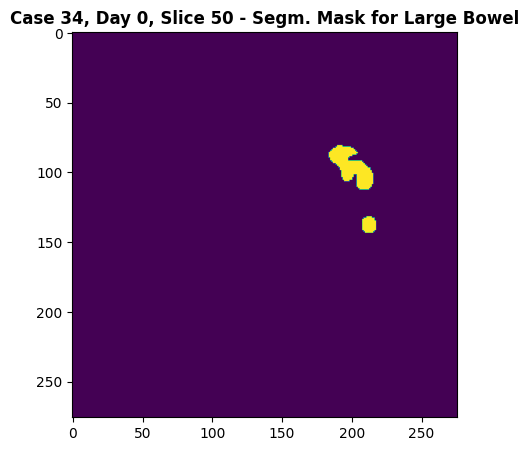

In [63]:
rle_string = '22547 4 22822 11 23096 15 23371 17 23646 19 23921 21 24197 20 24473 17 24749 15 25026 13 ' +\
'25302 13 25579 22 25856 22 26134 21 26411 21 26688 21 26965 22 27241 22 27518 22 27794 22 28070 23 ' +\
'28346 9 28357 12 28622 9 28633 12 28899 7 28909 12 29175 7 29185 12 29452 4 29461 12 29737 12 30013 12 ' +\
'30289 11 30565 11 30842 9 31119 7 36644 4 36918 8 37193 9 37469 10 37745 10 38021 10 38297 10 38573 10 ' +\
'38849 10 39125 10 39402 8 39679 6'

rle_dec_width = 276
rle_dec_height = 276

rle_dec_mask = rle_decode(rle_string, rle_dec_height, rle_dec_width)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

ax.set_title('Case 34, Day 0, Slice 50 - Segm. Mask for Large Bowel', fontweight='bold')

plt.imshow(rle_dec_mask)
plt.show()

## Codifica <strong> RLE </strong>

In [64]:
def rle_encode(mask: np.ndarray) -> str:
    """Funzione usata per generare una codifica RLE a partire da una maschera binaria

    Args:
        mask (np.ndarray): maschera binaria da codificare in RLE

    Returns:
        str: codifica RLE della maschera
    """
    
    rle_string = ""
    
    mask = mask.flatten()

    # Si aggiunge uno zero-padding alla maschera per evitare problemi di indicizzazione
    padded_mask = np.pad(mask, (1,), mode="constant")

    # Inizializza l'indice corrente a 0
    current_index = 0
    
    # Inizializza la lunghezza corrente a 0
    current_length = 0

    # Itera attraverso ciascun pixel della riga
    for pixel in padded_mask:
        # Se il pixel è 1 e il pixel precedente era 0, inizia una nuova sequenza
        if pixel == 1 and padded_mask[current_index - 1] == 0:
            rle_string += str(current_index) + " "
            current_length = 1
        # Se il pixel è 1 e il pixel precedente era 1, aumenta la lunghezza della sequenza corrente
        elif pixel == 1 and padded_mask[current_index - 1] == 1:
            current_length += 1
        # Se il pixel è 0 e il pixel precedente era 1, termina la sequenza corrente
        elif pixel == 0 and padded_mask[current_index - 1] == 1:
            rle_string += str(current_length) + " "
            current_length = 0
        
        # Incrementa l'indice corrente
        current_index += 1

    # Se c'è ancora una sequenza attiva alla fine della riga, termina la sequenza
    if current_length != 0:
        rle_string += str(current_length) + " "

    # Restituisci la stringa RLE
    return rle_string

Osserviamo, in quello che segue, come la funzione codifichi esattamente la maschera dell'esempio precedente

In [65]:
encoded_mask = rle_encode(rle_dec_mask/255)

print(f"Maschera codificata come:\n\033[1;34m{encoded_mask}\033[0m\n")

print(f"Stringa originale:\n\033[1;34m{rle_string}\033[0m\n")

Maschera codificata come:
22547 4 22822 11 23096 15 23371 17 23646 19 23921 21 24197 20 24473 17 24749 15 25026 13 25302 13 25579 22 25856 22 26134 21 26411 21 26688 21 26965 22 27241 22 27518 22 27794 22 28070 23 28346 9 28357 12 28622 9 28633 12 28899 7 28909 12 29175 7 29185 12 29452 4 29461 12 29737 12 30013 12 30289 11 30565 11 30842 9 31119 7 36644 4 36918 8 37193 9 37469 10 37745 10 38021 10 38297 10 38573 10 38849 10 39125 10 39402 8 39679 6 

Stringa originale:
22547 4 22822 11 23096 15 23371 17 23646 19 23921 21 24197 20 24473 17 24749 15 25026 13 25302 13 25579 22 25856 22 26134 21 26411 21 26688 21 26965 22 27241 22 27518 22 27794 22 28070 23 28346 9 28357 12 28622 9 28633 12 28899 7 28909 12 29175 7 29185 12 29452 4 29461 12 29737 12 30013 12 30289 11 30565 11 30842 9 31119 7 36644 4 36918 8 37193 9 37469 10 37745 10 38021 10 38297 10 38573 10 38849 10 39125 10 39402 8 39679 6



## Sovrapposizione slice e maschera corrispondente 

L'intenzione, avendo a disposizione le maschere, è quella di sovrapporle alle immagini, in modo da avere una migliore conoscenza del dominio in cui stiamo operando (i.e. saper individuare meglio a cosa corrisponde ogni segmento).

Allo scopo, abbiamo previsto una funzione, `override_mask_on_img` (riportata nel listato seguente).

In [5]:
def override_mask_on_img(mask_array: np.array, rgb_slice: cv.Mat) -> cv.Mat:
    """Funzione usata per sovrapporre una maschera ad un'immagine

    Args:
        mask_array (np.array): maschera da sovrapporre
        rgb_slice (Mat): immagine su cui applicare la maschera

    Returns:
        Mat: immagine con maschera sovrapposta
    """
    
    bool_index = mask_array != (0, 0, 0)

    rgb_slice[bool_index] = mask_array[bool_index]

    return rgb_slice

Ecco un esempio di codice che mostra l'output della funzione appena descritta.

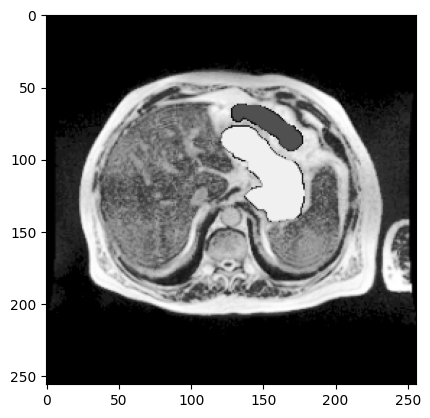

In [10]:
mask = cv.imread("../train/case118/case118_day0/masks/mask_slice_0031_276_276_1.63_1.63.png")
rgb_slice = cv.imread("../train/case118/case118_day0/scans/slice_0031_276_276_1.63_1.63.png")

overriden_w_mask = override_mask_on_img(mask_array=mask, rgb_slice=rgb_slice)

plt.imshow(np.array(overriden_w_mask), cmap='bone')
plt.show()

# <center id='paragrafo_5'> <strong>5 &dash; OPERAZIONI SULLE SLICE </strong> </center>
---

## Equalizzazione delle slice 

Un appunto va fatto alla qualità media delle immagini, di cui abbiamo avuto un assaggio nelle sezioni precedenti: i casi in cui sono facilmente distinguibili gli elementi dell'immagine sono pochi, mentre è più generale il caso di immagini **totalmente nere** o **poco contrastate**.

È necessario, allora, implementare una funzione che migliori la qualità delle scansioni presenti nel dataset. Nello specifico uno strumento che ben si presta al miglioramento del contrasto per immagini monocromatiche è l'equalizzazione dell'istogramma: riteniamo, infatti, che le immagini meno contrastate contengano comunque dell'informazione e, semplicemente, la poca qualità visiva sia data da un istogramma molto compattato sui neri; l'equalizzazione dell'istogramma permette di ottenere una distribuzione delle intensità **più uniforme**, con un conseguente miglioramento del contrasto.

Da un punto di vista implementativo, definiamo una funzione che, dato in input il percorso dell'immagine, la equalizza e la sovrascrive con la versione migliorata.

In [67]:
def equalizza_immagini(path: str):
    
    """Funzione usata per equalizzare un'immagine e sovrascriverla all'originale

    Args:
        path (str): percorso in cui salvare l'immagine
    """
    
    img = cv.imread(path, 0) 

    equ = cv.equalizeHist(img)
    
    cv.imwrite(path, equ)

# <center id='paragrafo_6'> <strong>6 &dash; DATA CLEANING, EQUALIZZAZIONE SLICE E CREAZIONE MASCHERE </strong> </center>
---

## Data cleaning 

Partendo dal dataframe **merged_df** ne viene creato uno nuovo, chiamato **merged_df_w_segmentation**, dal quale si vanno ad eliminare le righe e le corrispondenti slice il cui attributo `segmentation` non è presente. 

In [68]:
merged_df_w_segmentation = merged_df

for index, row in tqdm(merged_df_w_segmentation.iterrows(), total=len(merged_df_w_segmentation), bar_format=bar_format_green):
    if row['segmentation'] == '(nan, nan, nan)':
        merged_df_w_segmentation.drop(index, inplace=True)
        
merged_df_w_segmentation = merged_df_w_segmentation.reset_index(drop=True)

# salvo il DataFrame in formato CSV
merged_df_w_segmentation.to_csv(f'{DATAFRAMES_DIR}merged_df_w_segmentation.csv', index=False)

merged_df_w_segmentation.head()

100%|██████████| 38496/38496 [02:40<00:00, 240.12it/s]]


,id,case_id,day_id,slice_id,class,segmentation,slice_path,mask_path,slice_name,width,height,depth_px,is_created_mask,is_equalized_slice
0,case2_day1_slice_0050,2,1,50,"(0, 1, 2)","(nan, nan, '30207 7 30471 13 30733 19 30996 22...",./train/case2/case2_day1/scans/slice_0050_266_...,./train/case2/case2_day1/masks/mask_slice_0050...,slice_0050_266_266_1.50_1.50.png,266,266,1.5,False,False
1,case2_day1_slice_0051,2,1,51,"(0, 1, 2)","(nan, nan, '29942 9 30204 15 30466 20 30730 23...",./train/case2/case2_day1/scans/slice_0051_266_...,./train/case2/case2_day1/masks/mask_slice_0051...,slice_0051_266_266_1.50_1.50.png,266,266,1.5,False,False
2,case2_day1_slice_0052,2,1,52,"(0, 1, 2)","(nan, nan, '29412 6 29675 11 29938 17 30201 20...",./train/case2/case2_day1/scans/slice_0052_266_...,./train/case2/case2_day1/masks/mask_slice_0052...,slice_0052_266_266_1.50_1.50.png,266,266,1.5,False,False
3,case2_day1_slice_0053,2,1,53,"(0, 1, 2)","(nan, nan, '28614 13 28878 17 29142 19 29407 2...",./train/case2/case2_day1/scans/slice_0053_266_...,./train/case2/case2_day1/masks/mask_slice_0053...,slice_0053_266_266_1.50_1.50.png,266,266,1.5,False,False
4,case2_day1_slice_0054,2,1,54,"(0, 1, 2)","(nan, nan, '25429 7 25694 10 25960 11 26226 12...",./train/case2/case2_day1/scans/slice_0054_266_...,./train/case2/case2_day1/masks/mask_slice_0054...,slice_0054_266_266_1.50_1.50.png,266,266,1.5,False,False


## Equalizzazione slice 

Iniziamo le operazioni sulle immagini iterando su tutte le righe del dataframe **merged_df**, quindi equalizzando e sovrascrivendo tutte le immagini indicate in `slice_path`. \
Per farlo, usiamo il seguente listato:

In [75]:
merged_df_w_segmentation = pd.read_csv(f'{DATAFRAMES_DIR}merged_df_w_segmentation.csv')

# Imposta il numero di processi in parallelo
num_cores = multiprocessing.cpu_count()

def equalizza_immagini_parallel(row):
    if row['is_equalized_slice'] == False:
        equalizza_immagini(row['slice_path'])

print(f"\nInizio equalizzazione slice...\n")

# Esegui la funzione in parallelo su ogni riga del DataFrame
Parallel(n_jobs=num_cores)(delayed(equalizza_immagini_parallel)(row) for index, row in tqdm(merged_df_w_segmentation.iterrows(), total=len(merged_df_w_segmentation), bar_format=bar_format_blue))

print(f"\nFine equalizzazione slice.\n")

merged_df_w_segmentation['is_equalized_slice'] = True

# Salva il DataFrame in formato CSV
merged_df_w_segmentation.to_csv(f'{DATAFRAMES_DIR}merged_df_w_segmentation.csv', index=False)



Inizio equalizzazione slice...



100%|██████████| 16590/16590 [00:02<00:00, 5737.91it/s]]



Fine equalizzazione slice.



Il risultato dell'equalizzazione è andato oltre le aspettative, dato che immagini quasi totalmente nere (una percentuale di pixel bianchi minima) sono poi risultate in immagini qualitativamente buone, come si può vedere nell'esempio seguente.

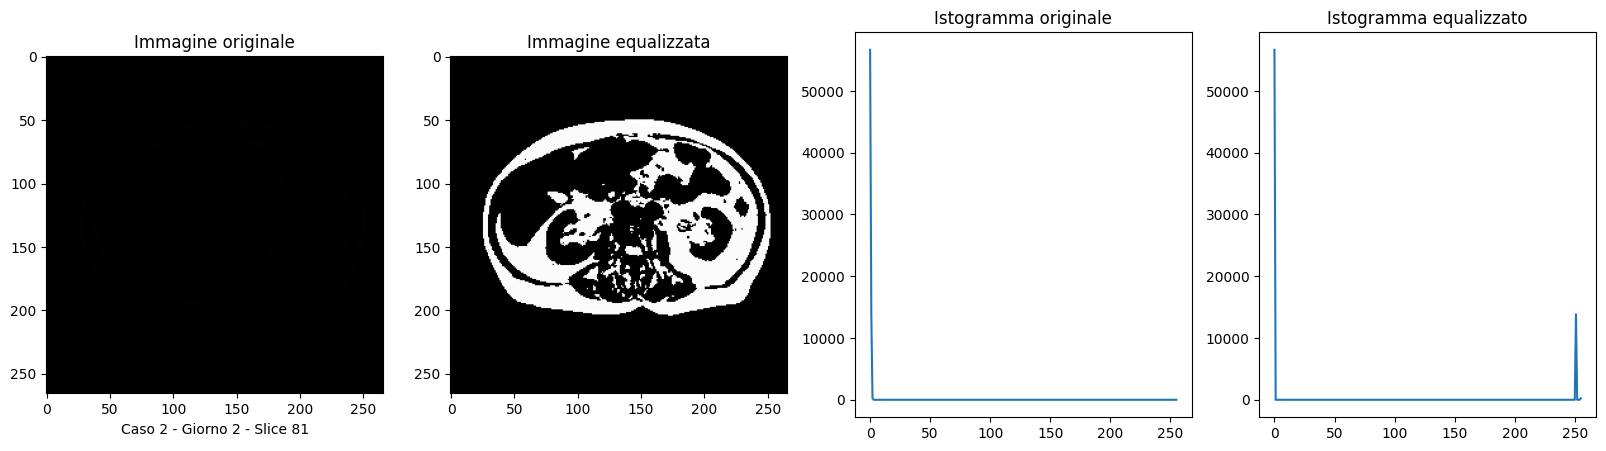

In [70]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))

ax1.set_title('Immagine originale')
ax1.set_xlabel("Caso 2 - Giorno 2 - Slice 81")
ax2.set_title('Immagine equalizzata')
ax3.set_title('Istogramma originale')
ax4.set_title('Istogramma equalizzato')

original = cv.imread(f'./images_nb/2_2_81_original.png')
equalised = cv.imread(f'./images_nb/2_2_81_equalised.png')

ax1.imshow(original)
ax2.imshow(equalised)
ax3.plot([_ for _ in range(256)], cv.calcHist([original], [0], None, [256], [0, 256]))
ax4.plot([_ for _ in range(256)], cv.calcHist([equalised], [0], None, [256], [0, 256]))

plt.show()

## Creazione maschere 

Avendo ottenuto un modo di decodificare delle stringhe RLE, vista l'enorme mole di dati e il formato *a triple* del nostro dataframe, pensiamo sia una buona idea la decodifica di tutte le segmentazioni per la generazione delle maschere associate ad ogni slice, salvata opportunamente nella cartella determinata da `mask_path` all'interno del dataframe. 
In questo modo, possiamo lavorare più immediatamente con le maschere e le immagini, senza doverle generare ad ogni esecuzione.

Per far ciò, iteriamo su tutte le righe del dataframe **merged_df** (`row`), eseguendo la seguente porzione di codice:

In [71]:
merged_df_w_segmentation = pd.read_csv(f'{DATAFRAMES_DIR}merged_df_w_segmentation.csv')

# Imposta il numero di processi in parallelo
num_cores = multiprocessing.cpu_count()

def create_mask(row):
    if row['is_created_mask'] == False: 
        
        rle_triple = row['segmentation'].strip('()').split(', ')
        
        l_b_segment = rle_decode(rle_triple[0], row['height'], row['width'])
        s_b_segment = rle_decode(rle_triple[1], row['height'], row['width'])
        s_segment = rle_decode(rle_triple[2], row['height'], row['width'])
        
        gray_mask = cv.add(l_b_segment, cv.add(s_b_segment, s_segment))
        
        gray_mask[l_b_segment != 0] = 80
        gray_mask[s_b_segment != 0] = 160
        gray_mask[s_segment != 0] = 240
        
        cv.imwrite(row['mask_path'], gray_mask)

print(f"\nInizio creazione maschere di segmentazione...\n")

Parallel(n_jobs=num_cores)(delayed(create_mask)(row) for _, row in tqdm(merged_df_w_segmentation.iterrows(), total=len(merged_df_w_segmentation), bar_format=bar_format_yellow))

print(f"\nFine creazione maschere di segmentazione.\n")

merged_df_w_segmentation['is_created_mask'] = True

# Salva il DataFrame in formato CSV
merged_df_w_segmentation.to_csv(f'{DATAFRAMES_DIR}merged_df_w_segmentation.csv', index=False)


Inizio creazione maschere di segmentazione...



100%|██████████| 16590/16590 [00:05<00:00, 2851.48it/s]]



Fine creazione maschere di segmentazione.



# <center id='paragrafo_7'> <strong>7 &dash; CROPPING E RESIZE DI SLICE E MASCHERE </strong> </center>
---

L'ultima operazione di data preprocessing consiste nell'omogeneizzare le dimensioni del dataset. Come visto nelle sezioni precedenti, abbiamo un numero abbastanza variabile di dimensioni e di layout, con quest'ultimo che spesso comporta l'acquisizione di parti non utili alla segmentazione del tratto gastrointestinale.

L'obiettivo di questa sezione è quella di **portare tutte le immagini alla stessa dimensione**, senza alterare l'*aspect ratio* della stessa. \
Innanzitutto, consideriamo le immagini rettangolari $360 \times 310$:

* Queste immagini presentano un layout in formato landscape, e costituiscono un *unicum* all'interno del dataset (oltretutto, rendono impossibile un
resize diretto dell'immagine in quanto verrebbe alterato l'*aspect ratio*);
* Osservandole è visibile come presentino contenuto non correlato al tratto gastrointestinale, quindi si può **tagliare del contenuto** per portarlo
 a un layout di tipo *portrait*

In virtù di queste considerazioni, e notando che il tratto gastrointestinale si trova praticamente al centro di queste scansioni, scegliamo di tagliarle
di `25px` a destra e a sinistra, per ottenere una shape `(310, 310)`.

Una volta rese quadrate tutte le immagini, possiamo operare un resize dell'intero dataset ad una shape desiderata, senza che queste comporti una grande perdita di dettaglio: la dimensione scelta è `(256, 256)`. \
Nel seguente listato vengono effettuate tutte le operazioni descritte.

In [72]:
ALTEZZA = 256
LARGHEZZA = 256

In [ ]:
merged_df_w_segmentation = pd.read_csv(f'{DATAFRAMES_DIR}merged_df_w_segmentation.csv')

print(f"\nInizio cropping e resize di maschere e slices...\n")

for index, riga in tqdm(merged_df_w_segmentation.iterrows(), total=len(merged_df_w_segmentation), bar_format=bar_format_green):

  # faccio un controllo per vedere se ho a che fare con immagini rettangolari
  if(riga['width'] == 360 & riga['height'] == 310):

    # se il controllo da esito positivo, effettuo il cropping dell'immagine
    scan = cv.imread(riga['slice_path'])[:, 25:335]
    maschera = cv.imread(riga['mask_path'])[:, 25:335]

    cv.imwrite(riga['slice_path'], scan)
    cv.imwrite(riga['mask_path'], maschera)
  
  # a prescindere dalla dimensione delle immagini, effettuo un resize, in modo
  # da avere tutte le immagini di dimensione 256x256 

  scan = cv.imread(riga['slice_path'])
  maschera = cv.imread(riga['mask_path'])
        
  resized_scan = cv.resize(scan, [LARGHEZZA, ALTEZZA])
  resized_mask = cv.resize(maschera, [LARGHEZZA, ALTEZZA]) 
        
  cv.imwrite(riga['slice_path'], resized_scan)
  cv.imwrite(riga['mask_path'], resized_mask)

print(f"\nOperazione avvenuta con successo!\n")

# aggiorno il dataframe, in modo da avere persistenza 
merged_df_w_segmentation['width'] = LARGHEZZA
merged_df_w_segmentation['height'] = ALTEZZA

# sovrascrivo il dataframe aggiornato
merged_df_w_segmentation.to_csv(f'{DATAFRAMES_DIR}merged_df_w_segmentation.csv', index=False)


Inizio cropping e resize di maschere e slices...



100%|██████████| 16590/16590 [01:13<00:00, 226.67it/s]]



Operazione avvenuta con successo!



<style>
  footer {
    color: #0f5b99;
    background-color: #f7f7f7;
    display: flex;
    justify-content: space-between;
    align-items: center;
    padding: 10px;
    box-shadow: 0 2px 4px rgba(0,0,0,0.2);
  }
  
  footer p {
    font-family: 'Montserrat', 'Arial', sans-serif;
    font-size: 16px;
    margin: 10px;
    text-shadow: 1px 1px #f7f7f7;
  }
  
  .team {
    text-align: left;
  }
  
  .subject {
    text-align: center;
  }
  
  .professor {
    text-align: right;
  }
</style>
<a href="#inizio">
  <footer>
    <p class="team"><strong>Vincenzo Fardella</strong> & <strong>Mario Tortorici</strong></p>
    <p class="subject"><strong>Big Data</strong> &copy; <strong>2023</strong></p>
    <p class="professor">Prof. <strong>Roberto Pirrone</strong></p>
  </footer>
</a>